In [1]:
!pip install torchdiffeq pygrinder pytorch_warmup matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from ode_model import *
from utils import *
import ode_model
import utils
import importlib
import run_model
from run_model import *
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import json
import pickle
from pygrinder import mcar

In [3]:
importlib.reload(run_model)
importlib.reload(ode_model)
importlib.reload(utils)

<module 'utils' from '/workspace/utils.py'>

In [4]:
np.random.seed(42)

## Load and prepare the data

In [5]:
!ls

CESTppmlist_7T.txt   __pycache__   run_model.py
Models		     ffn_model.py  trainModel.ipynb
ZSpecData_nopkl.npz  ode_model.py  utils.py


In [6]:
data = np.load("ZSpecData_nopkl.npz", allow_pickle = True)

In [7]:
zspec = data['trainData']
nonzeroInds = data['train_nonZeroInds']

zspec = zspec[nonzeroInds]
nonNanInds = data['train_nonNanInds']
zpsec = zspec[nonNanInds]
print(zspec.shape)
print(np.max(zspec))

(663397, 56, 3)
8492.899


In [8]:
B1 = np.array([28,50,70])
B1 = np.tile(B1, [zspec.shape[0], 1])
print(B1.shape)

(663397, 3)


In [9]:
zspec = np.swapaxes(zspec,1,-1)
zspec = zspec.reshape(-1,56)
print(zspec.shape)

B1 = B1.reshape(-1,1)
print(B1.shape)

(1990191, 56)
(1990191, 1)


In [10]:
satDur = 3
satDur = np.repeat(3, zspec.shape[0])
satDur = satDur.reshape(-1,1)
print(satDur.shape)

(1990191, 1)


In [11]:
offsets = np.loadtxt('CESTppmlist_7T.txt')
print(offsets)
print(len(offsets))

[-300.  -100.   -50.   -20.   -12.    -9.    -7.2   -6.2   -5.5   -4.7
   -4.    -3.3   -2.7   -2.    -1.7   -1.5   -1.1   -0.9   -0.6   -0.4
    0.     0.4    0.6    0.9    1.1    1.2    1.4    1.5    1.7    1.8
    2.     2.1    2.3    2.4    2.6    2.7    2.9    3.     3.2    3.3
    3.5    3.6    3.8    3.9    4.1    4.2    4.4    4.7    5.2    6.2
    8.    12.    20.    50.   100.   300. ]
56


In [12]:
trainIndsSelect = np.random.randint(low = 0, high = zspec.shape[0], size = int(10000))
zspec = zspec[trainIndsSelect,:]
B1 = B1[trainIndsSelect,:]
satDur = satDur[trainIndsSelect,:]

In [13]:
# normalize B1
B1 = (B1 - np.min(B1)) / (np.max(B1) - np.min(B1))
print(B1)

[[1.        ]
 [0.52380952]
 [0.52380952]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


### Create training and validation sets

In [14]:
# split data in training and validation sets
trainData, valData, trainInds, valInds = train_test_split(zspec,np.arange(len(zspec)),test_size = 0.3, random_state = 42)

train_B1 = B1[trainInds,:]
val_B1 = B1[valInds,:]

train_sat = satDur[trainInds,:]
val_sat = satDur[valInds,:]

In [15]:
X_train_ori = trainData
X_val_ori = valData

X_train = mcar(X_train_ori, 0.3)
X_val = mcar(X_val_ori, 0.2)

X_train_mask = ~np.isnan(X_train) + 0
X_val_mask = ~np.isnan(X_val) + 0

In [16]:
print(X_train[0,:])
print(X_train_mask[0,:])

[       nan 0.99434614 0.9878741  0.9856733         nan        nan
        nan 0.94849837 0.9334384         nan 0.8880286  0.86952394
        nan 0.8863322         nan 0.8769167  0.8717134  0.8523776
        nan 0.7610959  0.30816588 0.34228608        nan        nan
        nan        nan 0.8910882  0.8931315  0.9145171         nan
 0.90923417        nan 0.90869415 0.8921701  0.91293937 0.9158773
        nan 0.91964597 0.91244936 0.916553   0.91932255 0.9194456
        nan 0.9276481         nan 0.93367505 0.9363962         nan
 0.9421474  0.95245266 0.96153796 0.9714472  0.95824814 0.9863789
 0.99198514 0.9897099 ]
[0 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0
 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1]


In [17]:
offsets_train = np.tile(offsets, [X_train.shape[0], 1])
offsets_val = np.tile(offsets, [X_val.shape[0], 1])

# offsets_scaled = (offsets - np.min(offsets))/(np.max(offsets) - np.min(offsets))
# offsets_train = np.tile(offsets_scaled, [X_train.shape[0],1])
# offsets_val = np.tile(offsets_scaled, [X_val.shape[0],1])

In [18]:
trainDataset = MyCustomDataset(X_train, X_train_mask, train_B1, train_sat, X_train_ori, offsets_train)
valDataset = MyCustomDataset(X_val, X_val_mask, val_B1, val_sat, X_val_ori, offsets_val)

# trainLoader = DataLoader(trainDataset, batch_size = 256, shuffle = True, num_workers=8, pin_memory=True)
# valLoader = DataLoader(valDataset, batch_size = 1024, shuffle = False, num_workers=8, pin_memory=True)

trainLoader = DataLoader(trainDataset, batch_size = 64, shuffle = True)
valLoader = DataLoader(valDataset, batch_size = 1024, shuffle = False)

In [19]:
# train_offsets, train_spec, train_B1_batch, train_sat_batch, mask_batch, train_spec_ori = next(iter(trainLoader))
train_spec, train_B1_batch, train_sat_batch, mask_batch, train_spec_ori, train_offsets = next(iter(trainLoader))
# print(f"Offsets batch shape: {train_offsets.size()}")
print(f"Spectra batch shape: {train_spec.size()}")
print(f"B1 batch shape: {train_B1_batch.size()}")
print(f"Sat. duration batch shape: {train_sat_batch.size()}")
print(f"Mask batch shape: {mask_batch.size()}")
print(f"Original spectra batch shape: {train_spec_ori.size()}")
print(f"Train offsets batch shape: {train_offsets.size()}")

Spectra batch shape: torch.Size([64, 56])
B1 batch shape: torch.Size([64, 1])
Sat. duration batch shape: torch.Size([64, 1])
Mask batch shape: torch.Size([64, 56])
Original spectra batch shape: torch.Size([64, 56])
Train offsets batch shape: torch.Size([64, 56])


## Train the model

In [20]:
model_file_path = "Models"

In [21]:
params = {'input_dim':1,
          'seq_len': X_train_ori.shape[-1],
          'feature_dim': 8,
          'model_dim': 128,
          'inner_dim': 64,
          'ode_hidden_dim': 64,
          'state_dim': 3,
          'param_dim': 3,
          'latent_dim': 32,
          'n_heads': 2,
          'diag_attn_mask': True,
          'dropout': 0.1}

blochode = AttnODE(**params)

In [22]:
# indicate if training from scratch or learned weights
train_from_scratch = 1
model_name = 'AttnODE'

In [23]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)

if train_from_scratch:
    blochode.apply(init_weights)
else:
    chkpt_dir = 'Models/2025-05-03_03-29-34'
    chkpt_dict = torch.load(os.path.join(chkpt_dir,model_name + '_current.pth'), map_location = 'cuda')
    
    blochode.load_state_dict(chkpt_dict['model_state_dict'])
    
    optimizer = torch.optim.AdamW(blochode.parameters())
    optimizer.load_state_dict(chkpt_dict['optimizer_state_dict'])
    T_0 = int(0.02 * len(trainLoader.dataset))
    T_mult = 2
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = T_0, T_mult = T_mult, eta_min = 1e-6)
    scheduler.load_state_dict(chkpt_dict['scheduler_state_dict'])

In [ ]:
if not train_from_scratch:
    blochode_output, history = train(blochode,100,trainLoader,valLoader, model_file_path, 'AttnODE', optimizer, scheduler, chkpt_dir)
else:
    blochode_output, history = train(blochode,100,trainLoader,valLoader, model_file_path, 'AttnODE')

### Train a fully connected neural network

In [ ]:
trainDataset_ffn = TensorDataset(torch.tensor(np.concatenate([trainParams,train_B1,train_sat], axis = 1), dtype = torch.float32), torch.tensor(trainData, dtype = torch.float32))
valDataset_ffn = TensorDataset(torch.tensor(np.concatenate([valParams,val_B1,val_sat], axis = 1), dtype = torch.float32), torch.tensor(valData, dtype = torch.float32))

trainLoader_ffn = DataLoader(trainDataset_ffn, batch_size = 256, shuffle = True)
valLoader_ffn = DataLoader(valDataset_ffn, batch_size = 1024, shuffle = False)

In [ ]:
fullyconn_model = FFN(35, hidden_dim, output_dim)
print('The number of parameters in the fully-connected network are: ' + str(sum([p.numel() for p in fullyconn_model.parameters()])))

In [ ]:
ffn_history = train(fullyconn_model, epochs = 100, train_loader=trainLoader_ffn, val_loader=valLoader_ffn, model_save_path='Models', model_name='FFN')

## Test the model

### Test the Bloch ODE model

In [7]:
# load the best model
checkpoint = torch.load("Models/2025-05-06_03-16-55/AttnODE_best.pth", weights_only=True)
blochode.load_state_dict(checkpoint['model_state_dict'])

# checkpoint_ffn = torch.load(r"Models\2025-03-24_17-40-13\FFN.pth", weights_only=True)
# fullyconn_model.load_state_dict(checkpoint_ffn['model_state_dict'])

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [8]:
data.files

['trainData',
 'train_nonZeroInds',
 'train_nonNanInds',
 'testData',
 'test_nonZeroInds',
 'test_nonnanInds']

In [9]:
zspec_test = data['testData']
zspec_test = zspec_test[data['test_nonZeroInds']]
zspec_test = zspec_test[data['test_nonnanInds']]

print(zspec_test.shape)

(160506, 56, 3)


### Test the model on randomly selected spectra

In [19]:
X_test_ori = np.swapaxes(zspec_test, 1, -1)
X_test_ori = X_test_ori.reshape(-1,56)

X_test_mask = mcar(X_test_ori, 0.1)
mask_test = ~np.isnan(X_test_ori)  + 0

# offsets_test = np.tile(offsets + (-1*np.min(offsets)), [X_test_ori.shape[0],1]) / 1000.0
offsets_test = np.tile(offsets, [X_test_ori.shape[0],1])

B1 = np.array([28,50,70])
B1 = (B1 - np.min(B1)) / (np.max(B1) - np.min(B1))
B1_test = np.tile(B1, [zspec_test.shape[0], 1])
B1_test = B1_test.reshape(-1,1)

satDur = satDur[:X_test_ori.shape[0]]

In [20]:
print(X_test_ori.shape)
print(mask_test.shape)
print(X_test_mask.shape)
print(offsets_test.shape)
print(B1_test.shape)
print(satDur.shape)

(481518, 56)
(481518, 56)
(481518, 56)
(481518, 56)
(481518, 1)
(481518, 1)


In [21]:
testDataset = MyCustomDataset(X_test_mask, mask_test, B1_test, satDur, X_test_ori, offsets_test)
testLoader = DataLoader(testDataset, batch_size = 1024, shuffle=False)

In [22]:
spec, B1_batch, sat_batch, mask_batch, spec_ori, test_offsets = next(iter(testLoader))
# print(f"Offsets batch shape: {train_offsets.size()}")
print(f"Spectra batch shape: {spec.size()}")
print(f"B1 batch shape: {B1_batch.size()}")
print(f"Sat. duration batch shape: {sat_batch.size()}")
print(f"Mask batch shape: {mask_batch.size()}")
print(f"Original spectra batch shape: {spec_ori.size()}")
print(f"Train offsets batch shape: {test_offsets.size()}")

Spectra batch shape: torch.Size([1024, 56])
B1 batch shape: torch.Size([1024, 1])
Sat. duration batch shape: torch.Size([1024, 1])
Mask batch shape: torch.Size([1024, 56])
Original spectra batch shape: torch.Size([1024, 56])
Train offsets batch shape: torch.Size([1024, 56])


In [26]:
zspec_test_model_output = test(blochode, testLoader)

In [27]:
zspec_test_model_output.shape

(481518, 56)

(-5.0, 5.0)

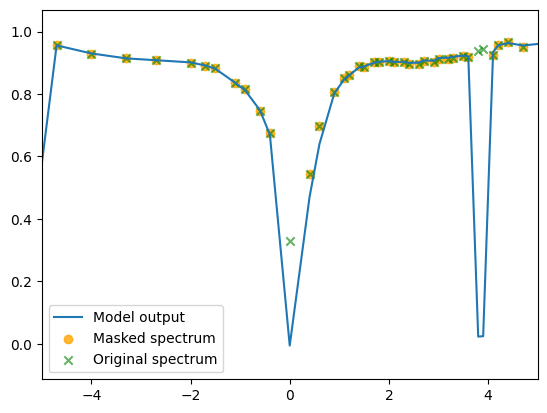

In [45]:
specNum = 10000
plt.plot(offsets, zspec_test_model_output[specNum,:], label = 'Model output')
plt.scatter(offsets, X_test_mask[specNum,:], label = 'Masked spectrum', alpha = 0.8, c = 'orange')
plt.scatter(offsets, X_test_ori[specNum,:], label = 'Original spectrum', c = 'green', marker = 'x', alpha = 0.6)
# plt.plot(offsets, np.abs(zspec_test_model_output[specNum,:] - X_test_ori[specNum,:]), label = 'Residual')
plt.legend()
plt.xlim([-5,5])

In [ ]:
print(np.sum([p.numel() for p in blochode.parameters()]))

### Test the FFN model

In [ ]:
testDataset_ffn = TensorDataset(torch.tensor(np.concatenate([params_test_select, B1_test_select, sat_test_select], axis = 1), dtype = torch.float32),
                                torch.tensor(zspec_test_select, dtype = torch.float32))

testLoader_ffn = DataLoader(testDataset_ffn)

In [ ]:
zspec_test_ffn_output = test_ffn(fullyconn_model, testLoader_ffn)

In [ ]:
specNum = 4000
plt.plot(offsets, zspec_test_ffn_output[specNum,:], label = 'Model output')
plt.scatter(offsets, zspec_test_select[specNum,:], label = 'Original spectrum', alpha = 0.6, c = 'orange')
plt.plot(offsets, zspec_test_ffn_output[specNum,:] - zspec_test_select[specNum,:], label = 'Residual')
plt.xlim([-5,5])
plt.legend()

### Calculate root mean squared error on test reuslts

In [ ]:
test_recon_error = np.sqrt(np.mean((zspec_test_model_output - zspec_test_select)**2, axis = 0))
test_recon_error = np.mean(test_recon_error)
print(test_recon_error)

In [ ]:
ffn_test_recon_error = np.mean((zspec_test_ffn_output - zspec_test_select)**2, axis = 0)
ffn_test_recon_error = np.mean(ffn_test_recon_error)
print(ffn_test_recon_error)